In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

import torch
from torch.utils.data import DataLoader, TensorDataset
from model import FeedForward

In [2]:
# takes angle in degrees, return in radians or degrees
def wrap_angle(angle, radians=True):
    wrapped_angle = (angle + 180) % 360 - 180
    if radians:
        wrapped_angle = np.deg2rad(wrapped_angle)
    return wrapped_angle

def get_ee_effective_mass(mass_matrix, direction):
    x_mass = mass_matrix[0][0]
    y_mass = mass_matrix[1][1]
    return np.dot(np.abs(direction), [x_mass, y_mass])

def get_forward_prediction(start_pose, control_params, object_params, robot_params):
    start_x, start_y, start_theta = start_pose
    xy_vel = np.array(control_params['ee_vel'])
    m_obj = object_params['mass']
    mu = object_params['mu']
    size = object_params['size']
    g = -9.81
    
    contour_pt = control_params['contour_pt'][:2]
    
    # treat object as point mass for translation
    m_ee = get_ee_effective_mass(robot_params['inertia'], xy_vel / np.linalg.norm(xy_vel))
    v0 = m_ee * xy_vel / (m_ee + m_obj)
    D = -0.5 * v0**2 / (mu * g)
    predicted_x = start_x + np.sign(v0[0]) * D[0]
    predicted_y = start_y + np.sign(v0[1]) * D[1]
    
    # treat object as disc for rotation
    # current setup assumes cubical object
    r1 = np.array([[size[0]/2, 0], [-size[0]/2, 0], [0, size[0]/2], [0, -size[0]/2]])
    rot_mat = np.array([[np.cos(start_theta), -np.sin(start_theta)], [np.sin(start_theta), np.cos(start_theta)]])
    r1 = np.matmul(rot_mat, r1.transpose())    
    
    aa = np.array([start_x + r1[0], start_y + r1[1]])
    dist1 = np.linalg.norm(contour_pt - aa.transpose(), axis=1)
    
    dist1[np.argmin(dist1)] = np.inf
    second_min = aa[:, np.argmin(dist1)]
    
    u = np.array([contour_pt[0]-start_x, contour_pt[1]-start_y])
    v = np.array([second_min[0] - start_x, second_min[1]-start_y])
    v_norm = np.linalg.norm(v)
    r = (np.dot(np.squeeze(u), np.squeeze(v))/v_norm**2)*v
    
    omega = np.linalg.norm(v0) / np.linalg.norm(r)
    del_theta = 3*np.linalg.norm(r)*omega**2/(4*mu*g)
    predicted_theta = start_pose[2] + del_theta  # wrap
    predicted_theta = wrap_angle(np.rad2deg(predicted_theta))
    
    return predicted_x, predicted_y, predicted_theta

def calculate_error(predicted_pose, target_pose, separate_positional_error=False):
    angle_diff = np.rad2deg(target_pose[2] - predicted_pose[2])
    angular_error = wrap_angle(angle_diff)
    if separate_positional_error:
        error = [abs(target_pose[0] - predicted_pose[0]),
                 abs(target_pose[1] - predicted_pose[1]),
                 angular_error]
    else:
        error = [np.linalg.norm(np.array(target_pose[:2]) - np.array(predicted_pose[:2])),
                 angular_error]
    
    return error

def evaluate_model(model_type, start_poses, end_poses, contour_pts, ee_vels, **kwargs):
    displacements = []
    errors = []
    predictions = []
    
    if model_type == 'analytical':
        if 'inertia_matrices' in kwargs:
            inertia_matrices = kwargs['inertia_matrices']
        assert(len(inertia_matrices) != 0)

        for idx, start_pose in enumerate(start_poses):
            end_pose = end_poses[idx]

            control_params = {'ee_vel': ee_vels[idx], 'contour_pt': contour_pts[idx]}
            robot_params = {'inertia': inertia_matrices[idx]}
            predicted_pose = get_forward_prediction(start_pose, control_params, object_params, robot_params)
            
            errors.append(calculate_error(predicted_pose, end_pose, separate_positional_error=False)[0])
            displacements.append(calculate_error(start_pose, end_pose, separate_positional_error=False)[0])
            predictions.append(predicted_pose)
    elif model_type == 'learning':
        model_name = "position_model.pt"
        model = FeedForward(8, 2)
        model.load_state_dict(torch.load("models/" + model_name))
        model.train(False)

        inputs = np.concatenate([start_poses, contour_pts, ee_vels], axis=1)
        test_dataset = TensorDataset(torch.tensor(inputs), torch.tensor(end_poses))
        test_loader = DataLoader(test_dataset, batch_size=128, num_workers=32, shuffle=False)

        for i, data in enumerate(test_loader):
            X, y = data
            pred = model(X).detach().numpy()
            predictions.append(pred)
            for j in range(pred.shape[0]):
                disp = np.linalg.norm(np.array(X[j, :2]) - np.array(y[j, :2]))
                err = np.linalg.norm(np.array(pred[j, :]) - np.array(y[j, :2]))
                displacements.append(disp)
                errors.append(err)
        predictions = np.concatenate(predictions, axis=0)
                
    return np.array(displacements), np.array(errors), np.array(predictions)

def plot_pose_distributions(start, end, predicted):
    fig, ax = plt.subplots(3, 2)
    ax[0, 0].hist(start[:, 0])
    ax[0, 1].hist(start[:, 1])
    ax[1, 0].hist(end[:, 0])
    ax[1, 1].hist(end[:, 1])
    ax[2, 0].hist(predicted[:, 0])
    ax[2, 1].hist(predicted[:, 1])

    plt.setp(ax[:, 0], xlim=[0.25, 1])
    plt.setp(ax[:, 1], xlim=[-0.375, 0.375])
    cols = ['X', 'Y']
    for a, col in zip(ax[0], cols):
        a.set_title(col)
    rows = ['Start', 'End', 'Predicted']
    for a, row in zip(ax[:,0], rows):
        a.set_ylabel(row, size='large')
    fig.suptitle('Distribution of Poses over Table', fontsize=16)
    fig.tight_layout()

    plt.show()

def plot_displacement_vs_l1_norm(displacements, errors):
    bins = np.arange(0, 0.31, 0.01)
    inds = np.digitize(displacements, bins=bins)
    # create mapping from bins to list of values
    bin_values = defaultdict(list)
    for i in range(len(displacements)):
        bin_values[bins[inds[i] - 1]].append(errors[i])

    # only plot bins with values
    bins_plt = np.array([b for b in bins if bin_values[b]])
    means = np.array([np.mean(bin_values[b]) for b in bins if bin_values[b]])
    std = np.array([np.std(bin_values[b]) for b in bins if bin_values[b]])

    plt.plot(bins_plt, means, '-', color="black")
    plt.fill_between(bins_plt, means - std, means + std, color='gray', alpha=0.4)
    plt.scatter(displacements, errors)
    plt.xlabel("Displacement (m)")
    plt.ylabel("L1 Norm")
    plt.show()

In [3]:
contour_pts = np.load('data/test_contour_pt.npy')
ee_vels = np.load('data/test_ee_vel.npy')
start_poses = np.load('data/test_start_pose.npy')
end_poses = np.load('data/test_end_pose.npy')

# for analytical model
inertia_matrices = np.load('data/inertia_matrix.npy')
object_params = {'mass': 0.1, 'mu': 0.15, 'size': [0.1, 0.1, 0.1]}

# Test Set Analysis, n=736

### Analytical Model

In [4]:
displacements, errors, predicted_poses = \
    evaluate_model('analytical', start_poses, end_poses, contour_pts, ee_vels, inertia_matrices=inertia_matrices)

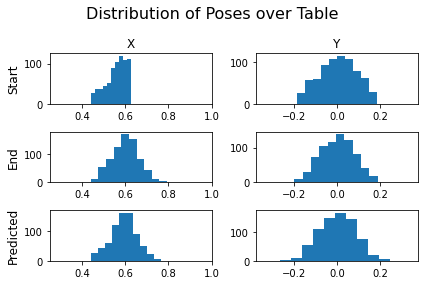

In [5]:
plot_pose_distributions(start_poses, end_poses, predicted_poses)

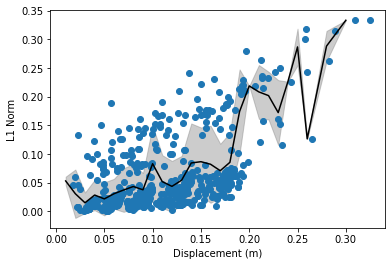

In [6]:
plot_displacement_vs_l1_norm(displacements, errors)

### Learning Model

In [7]:
displacements, errors, predicted_poses = \
    evaluate_model('learning', start_poses, end_poses, contour_pts, ee_vels)

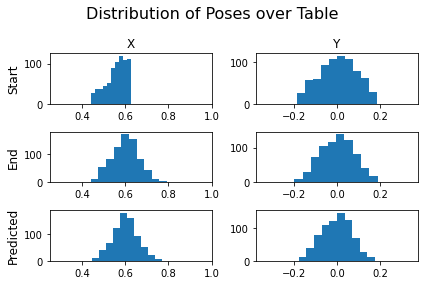

In [8]:
plot_pose_distributions(start_poses, end_poses, predicted_poses)

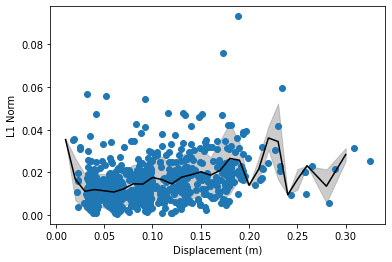

In [9]:
plot_displacement_vs_l1_norm(displacements, errors)